<a href="https://colab.research.google.com/github/anjali-anjalii/Predicting-Fraud-in-Financial-Payment-Services/blob/main/PredictingFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from mpl_toolkits.mplot3d import Axes3D
import warnings

In [2]:
warnings.filterwarnings(action = "ignore", category = DeprecationWarning)

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PS_20174392719_1491204439457_log.csv")

In [5]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
df.isnull().values.any()

False

In [7]:
# finding the types of fraudulent transactions in our dataset
print(f"Types of Fraudulent transaction: {df.loc[df.isFraud == 1].type.drop_duplicates().values}")
# there are two types of fraudulent transactions: TRANSFER, CASH_OUT
# let's find the total number of fraudulent TRANSFERs and CASH_OUTs
transfer = df.loc[df.type == "TRANSFER"]
cashout = df.loc[df.type == "CASH_OUT"]
fraudTransfer = df.loc[(df.isFraud == 1) & (df.type == "TRANSFER")]
fraudCashout = df.loc[(df.isFraud == 1) & (df.type == "CASH_OUT")]
print(f"Total number of fraudulent TRANSFERs: {len(fraudTransfer)}")
print(f"Total number of fraudulent CASH_OUTs: {len(fraudCashout)}")

Types of Fraudulent transaction: ['TRANSFER' 'CASH_OUT']
Total number of fraudulent TRANSFERs: 4097
Total number of fraudulent CASH_OUTs: 4116


In [8]:
# finding the conditions that tells if a feature isFlaggedFraud set or not according the dataset description a transaction of more than
# 200000 is flagged to contol massive transfers from one account to another but as we can observe, isFlaggedFraud can remain not set
# even after this condition is met
flagged = df.loc[df.isFlaggedFraud == 1]
not_flagged = df.loc[df.isFlaggedFraud == 0]
print(f"Type of transaction that isFlaggedFraud: {flagged.type.drop_duplicates().values}")
print(f"Minimum amount when isFlaggedFraud == 1: {flagged.amount.min()}")
print(f"Maximum amount when isFlaggedFraud == 0: {transfer.loc[transfer.isFlaggedFraud == 0].amount.max()}")
print(f"Number of TRANSFERs where isFlaggedFraud = 0, and oldbalanceDest = newbalanceDest = 0: {len(transfer.loc[(transfer.isFlaggedFraud == 0) & (transfer.oldbalanceDest == 0) & (transfer.newbalanceDest == 0)])}")
print(f"Minimum and Maximum of oldbalanceOrg for isFlaggedFraud = 1: {[round(flagged.oldbalanceOrg.min()), round(flagged.oldbalanceOrg.max())]}")
print(f"Minimum and Maximum of oldbalanceOrg for isFlaggedFraud = 0 and oldbalanceOrg = newbalanceOrig: {transfer.loc[(transfer.isFlaggedFraud == 0) & (transfer.oldbalanceOrg == transfer.newbalanceOrig)].oldbalanceOrg.min(), round(transfer.loc[(transfer.isFlaggedFraud == 0) & (transfer.oldbalanceOrg == transfer.newbalanceOrig)].oldbalanceOrg.max())}")


Type of transaction that isFlaggedFraud: ['TRANSFER']
Minimum amount when isFlaggedFraud == 1: 353874.22
Maximum amount when isFlaggedFraud == 0: 92445516.64
Number of TRANSFERs where isFlaggedFraud = 0, and oldbalanceDest = newbalanceDest = 0: 4158
Minimum and Maximum of oldbalanceOrg for isFlaggedFraud = 1: [353874, 19585040]
Minimum and Maximum of oldbalanceOrg for isFlaggedFraud = 0 and oldbalanceOrg = newbalanceOrig: (0.0, 575668)


In [9]:
print(f"Originators flagged as fraud transacted more than once?: {flagged.nameOrig.isin(pd.concat([not_flagged.nameOrig, not_flagged.nameDest])).any()}")
print(f"Destinations flagged as fraud has been used as originator?: {(flagged.nameDest.isin(not_flagged.nameDest)).any()}")
print(f"Destinations flagged as fraud have been destined more than once?: {sum(flagged.nameDest.isin(not_flagged.nameDest))}")

Originators flagged as fraud transacted more than once?: False
Destinations flagged as fraud has been used as originator?: True
Destinations flagged as fraud have been destined more than once?: 2


Hence, from the above analysis we can colclude that the isFlaggedFraud is set in an incomprehensible manner and we can discard it without worrying about the information loss.

In [16]:
print(f"Fraudulent TRANSFER destinations that are also originators for CASH_OUT?: {(fraudTransfer.nameDest.isin(fraudCashout.nameOrig)).any()}")

Fraudulent TRANSFER destinations that are also originators for CASH_OUT?: False


In [10]:
# as the fraudulents occur in TRANSFER and CASH_OUT hence, we use their data only
X = df.loc[(df.type == "TRANSFER")|(df.type == "CASH_OUT")]
Y = X["isFraud"]
del X["isFraud"]
X = X.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis = 1)
# binary encoding of labelled data
X.loc[X.type == "TRANSFER", "type"] = 0
X.loc[X.type == "CASH_OUT", "type"] = 1
X.type = X.type.astype(int)
print(X.head())

    step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0             0.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  
2             0.00  
3             0.00  
15        51513.44  
19            0.00  
24      2719172.89  


In [11]:
X_fraud = X.loc[Y == 1]
X_not_fraud = X.loc[Y == 0]
print(f"Fraction of fraudulent transactions with oldBalanceDest = newBalanceDest = 0 when transaction amount is non-zero is: {len(X_fraud.loc[(X_fraud.oldbalanceDest == 0) & (X_fraud.newbalanceDest == 0) & (X_fraud.amount)])/ (1.0*len(X_fraud))}")
print(f"Fraction of genuine transactions with oldBalanceDest = newBalanceDest = 0 when transaction amount is non-zero is: {len(X_not_fraud.loc[(X_not_fraud.oldbalanceDest == 0) & (X_not_fraud.newbalanceDest == 0) & (X_not_fraud.amount)])/ (1.0*len(X_not_fraud))}")


Fraction of fraudulent transactions with oldBalanceDest = newBalanceDest = 0 when transaction amount is non-zero is: 0.4955558261293072
Fraction of genuine transactions with oldBalanceDest = newBalanceDest = 0 when transaction amount is non-zero is: 0.0006176245277308345


In [12]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), ["oldbalanceDest", "newbalanceDest"]] = -1
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), ["oldbalanceDest", "newbalanceDest"]] = np.nan

In [13]:
X["errorbalanceOrig"] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X["errorbalanceDest"] = X.oldbalanceOrg + X.amount - X.newbalanceDest

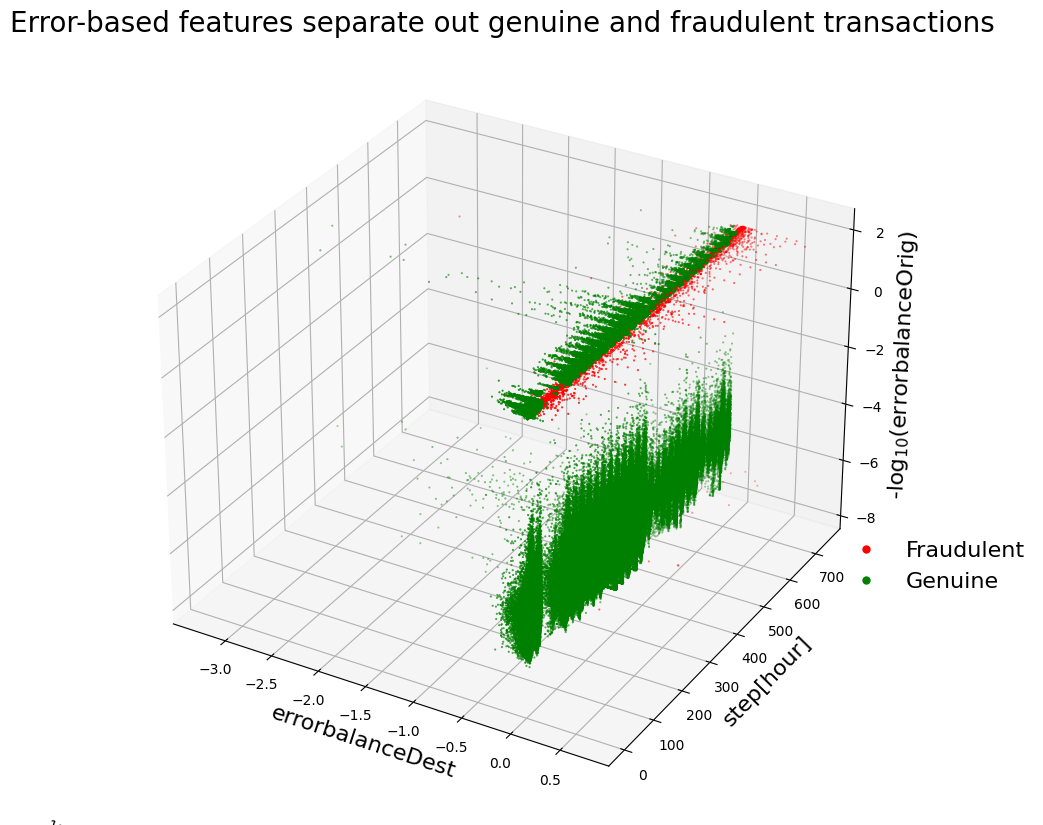

In [17]:
x = "errorbalanceDest"
y = "step"
z = "errorbalanceOrig"
z_offset = 0.02
limit = len(X)
sns.reset_orig()
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(X.loc[Y==0, x][:limit], X.loc[Y==0, y][:limit], -np.log10(X.loc[Y==0, z][:limit] + z_offset), c = "g", marker = ".", s=1, label = "Genuine")
ax.scatter(X.loc[Y==1, x][:limit], X.loc[Y==1, y][:limit], -np.log10(X.loc[Y==1, z][:limit] + z_offset), c = "r", marker = ".", s=1, label = "Fraudulent")
ax.set_xlabel(x, size = 16)
ax.set_ylabel(y + "[hour]", size = 16)
ax.set_zlabel("-log$_{10}$("+z+")", size = 16)
ax.set_title("Error-based features separate out genuine and fraudulent transactions", size = 20)
plt.axis("tight")
ax.grid(1)
nofraudMarker = mlines.Line2D([], [], linewidth = 0, color = "g", marker = ".", markersize = 10, label = "Genuine")
fraudMarker = mlines.Line2D([], [], linewidth = 0, color = "r", marker = ".", markersize = 10, label = "Fraudulent")
plt.legend(handles = [nofraudMarker, fraudMarker], bbox_to_anchor = (1.20, 0.38), frameon = False, prop = {"size":16})


[Text(1, -1.0, '−1.0'),
 Text(1, -0.5, '−0.5'),
 Text(1, 0.0, '0.0'),
 Text(1, 0.5, '0.5'),
 Text(1, 1.0, '1.0')]

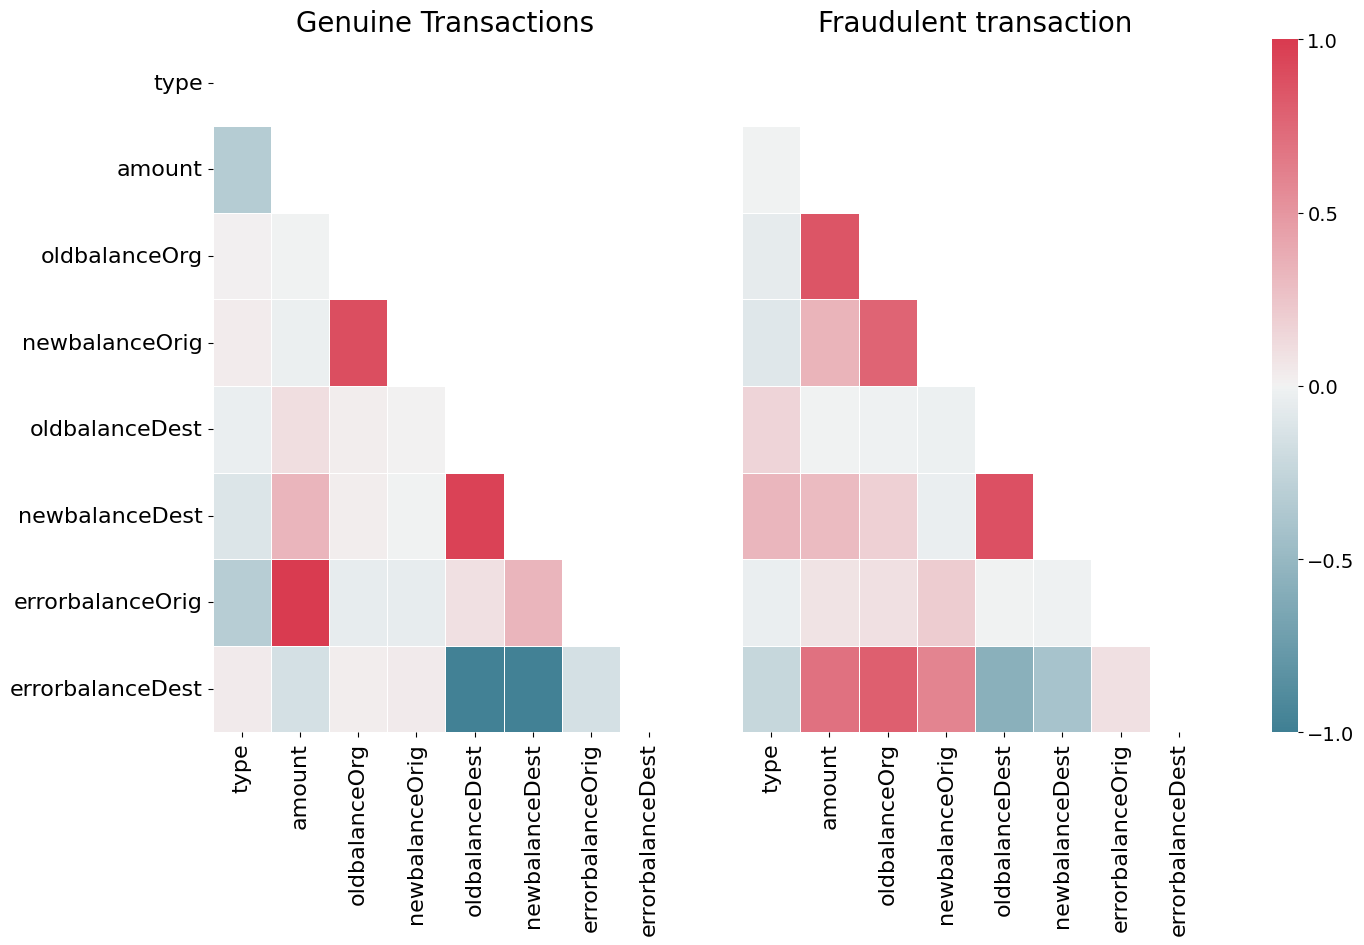

In [40]:
Xfraud = X.loc[Y==1]
XNonFraud = X.loc[Y==0]
correlationNonFraud = XNonFraud.loc[:,X.columns != "step"].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw = grid_kws, figsize = (14, 9))
cmap = sns.diverging_palette(220, 8, as_cmap = True)
ax1 = sns.heatmap(correlationNonFraud, ax=ax1, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16)
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16)
ax1.set_title("Genuine Transactions", size = 20)

correlationFraud = Xfraud.loc[:,X.columns != "step"].corr()
ax2 = sns.heatmap(correlationFraud, ax=ax2, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, mask = mask, \
                  yticklabels=False, cbar_ax = cbar_ax, cbar_kws = {"orientation":"vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16)
ax2.set_title("Fraudulent transaction", size = 20)
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14)


In [23]:
print(f"skew = {len(Xfraud)/float(len(X))}")

skew = 0.002964544224336551


In [26]:
randomState = 5
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state = randomState)


In [28]:
weights = (Y==0).sum()/(1.0*(Y==1).sum())
model = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = model.fit(Xtrain, Ytrain).predict_proba(Xtest)
auprc = average_precision_score(Ytest, probabilities[:,1])
print(f"AUPRC =  {auprc}")

AUPRC =  0.9914218159047365


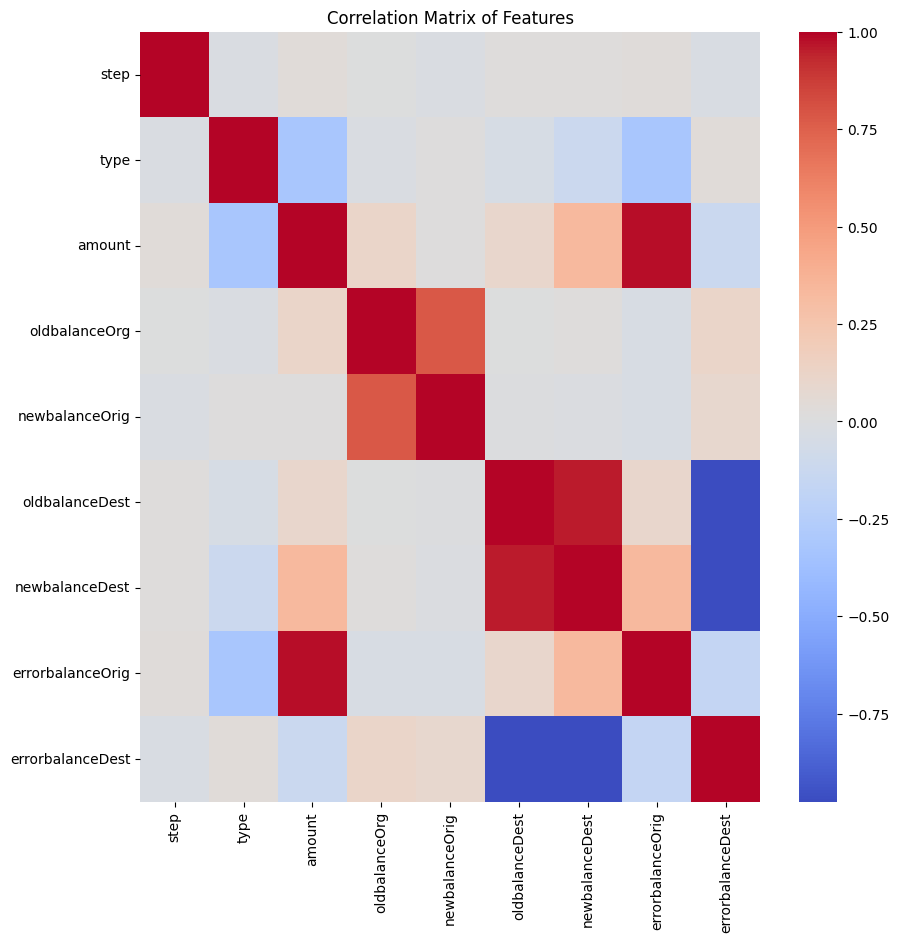

In [35]:
corr_matrix = Xtrain.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 10))  # Adjust figure size as needed
sns.heatmap(corr_matrix,cmap="coolwarm")
plt.title('Correlation Matrix of Features')
plt.show()

Text(0.5, 1.0, 'Features Importance')

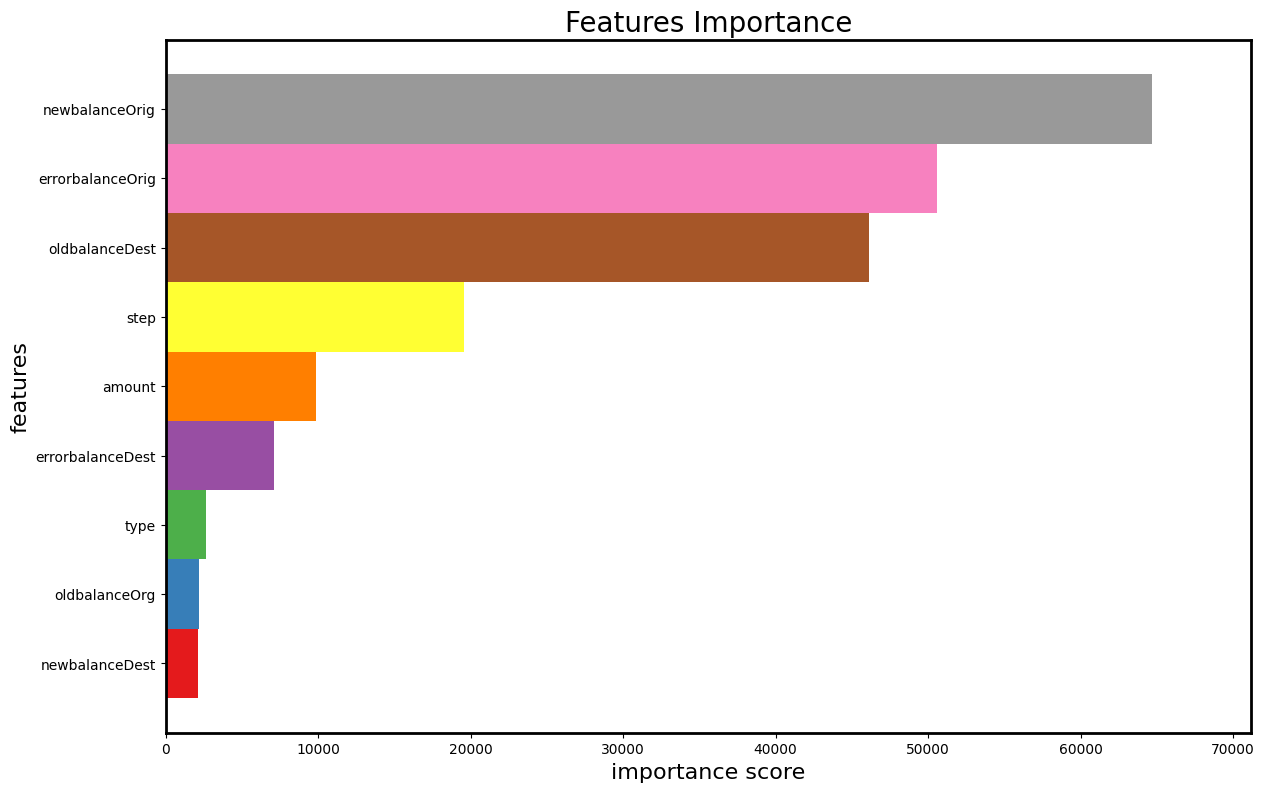

In [33]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = plot_importance(model, height = 1, color = colours, grid = False, show_values = False, importance_type = "cover", ax = ax)
for axis in ["top", "bottom", "left", "right"]:
  ax.spines[axis].set_linewidth(2)
ax.set_xlabel("importance score", size = 16)
ax.set_ylabel("features", size = 16)
ax.set_title("Features Importance", size = 20)